In [1]:
import fitz
import random
import pandas as pd
import textwrap

from spacy.lang.en import English
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer


model_name = 'all-mpnet-base-v2'

c:\Users\Taba\Desktop\Repository\research-rag\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Document Imports

In [2]:
# Get PDF document
pdf_path = "papers/2503.15946v1.pdf"

In [3]:
#Todo - comment better in future
def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n", " ").strip() 

    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:

    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  
        text = page.get_text() 
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, 
                                "text": text})
    return pages_and_texts

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

print("### PAGE SAMPLE ###")

print_wrapped(pages_and_texts[0]['text'])

12it [00:00, 227.39it/s]

### PAGE SAMPLE ###
ITADATA2024: The 3rd Italian Conference on Big Data and Data Science
Multivariate Time Series Anomaly Detection in Industry 5.0 Lorenzo
Colombi1[0009−0004−9681−9842], Michela Vespa1[0009−0004−4350−8151], Nicolas
Belletti1[0009−0006−6053−433X], Matteo Brina1[0009−0003−2363−8509], Simon
Dahdal1[0000−0002−7335−9773], Filippo Tabanelli1[0009−0008−9661−394X], Elena
Bellodi1[0000−0002−3717−3779], Mauro Tortonesi1[0000−0002−7417−4455], Cesare
Stefanelli1[0000−0003−4617−1836], and Massimiliano Vignoli2 1 University of
Ferrara, Ferrara, Italy {firstname.lastname}@unife.it 2 Bonfiglioli S.P.A., Via
Cav. Clementino Bonfiglioli, 1, Calderara di Reno, Italy
massimiliano.vignoli@bonfiglioli.com Abstract. Industry 5.0 environments present
a critical need for effective anomaly detection methods that can indicate
equipment malfunctions, process inefficiencies, or potential safety hazards. The
ever-increasing sensorization of manufacturing lines makes processes more
observable, but a

In [4]:
# PDF Statistics
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,12.00,12.00,12.00,12.00,12.00
mean,5.50,2879.75,424.17,23.42,719.94
std,3.61,643.01,101.37,10.26,160.75
min,0.00,1319.00,166.00,14.00,329.75
25%,2.75,2540.50,372.25,19.50,635.12
50%,5.50,3007.50,458.50,21.00,751.88
75%,8.25,3383.00,492.00,23.75,845.75
max,11.00,3567.00,521.00,54.00,891.75


# Text Processing + Embeddings

In [5]:
verbose = False

nlp = English()

nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Convert from spaCy datatype to strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])

df = pd.DataFrame(pages_and_texts)

# Page statistics
if verbose:
    df.describe().round(2)

100%|██████████| 12/12 [00:00<00:00, 226.79it/s]


In [6]:
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through text and split sentences into chuncks

for item in tqdm(pages_and_texts):
    item["sentences_chuck"] = split_list(input_list=item["sentences"],
                                        slice_size=num_sentence_chunk_size)
    
    item["num_chuncks"] = len(item["sentences_chuck"])

df = pd.DataFrame(pages_and_texts)

if verbose:
    df.describe().round(2)

100%|██████████| 12/12 [00:00<00:00, 39383.14it/s]


In [7]:
import re

# Split each chunk into its own item

pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentences_chuck"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the senteces together into paragraph-like structure
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) #Add a space after a Capital Letter
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

print(len(pages_and_chunks))

df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

100%|██████████| 12/12 [00:00<00:00, 9284.57it/s]

33


,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,33.00,33.00,33.00,33.00
mean,5.76,1045.88,153.58,261.47
std,3.56,504.66,78.25,126.17
min,0.00,149.00,17.00,37.25
25%,3.00,679.00,84.00,169.75
50%,6.00,1145.00,181.00,286.25
75%,9.00,1467.00,223.00,366.75
max,11.00,2165.00,288.00,541.25


In [8]:
# Create a filter to get rid off chunks with under 30 tokens
filter = False
if filter:
    min_token_length = 30
    for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
        print(f"Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

        pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
    pages_and_chunks_over_min_token_len[:2]

# Embedding

In [9]:
embedding_model = SentenceTransformer(model_name_or_path=model_name,
                                      device="cuda")

In [10]:
# Uploading one by one

for item in tqdm(pages_and_chunks):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]

text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

100%|██████████| 33/33 [00:00<00:00, 40.09it/s]


# Save embeddings to file

In [ ]:
text_chunk_embeddings_df = pd.DataFrame(pages_and_chunks)
embeddings_df_save_path = "embeddings.csv"
text_chunk_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [12]:
text_chunk_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunk_embeddings_df_load.head(5)

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,ITADATA2024: The 3rd Italian Conference on Big...,2165,258,541.25,[-8.80195573e-02 7.39596933e-02 -4.45798375e-...
1,0,ML and MLOps applications optimize industrial ...,687,92,171.75,[-6.14798181e-02 1.68733075e-02 -2.18382236e-...
2,1,2 of such anomalies is crucial for maintaining...,1375,191,343.75,[-6.00930192e-02 4.90075946e-02 -3.05548925e-...
3,1,"Jointly with AEs, various ML algorithms are co...",1563,235,390.75,[-5.60930297e-02 1.55177955e-02 -2.64358725e-...
4,1,The paper is organized as follows: Section 2 i...,411,63,102.75,[-5.21317795e-02 6.03054911e-02 -3.69464010e-...


In [13]:
import torch
import numpy as np

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunk_embeddings_df = pd.read_csv("embeddings2.csv")
text_chunk_embeddings_df["embedding"].iloc[0]

'[-8.80195573e-02  7.39596933e-02 -4.45798375e-02  4.38563935e-02\n -1.38666164e-02 -6.66816207e-03  7.70827979e-02  2.59963907e-02\n -1.43390168e-02  2.97497809e-02  7.54917338e-02  4.61364836e-02\n -3.97860035e-02  6.97908103e-02  5.43059641e-03  1.65246241e-02\n  3.36265936e-02 -1.42976176e-02 -1.67800987e-04  3.38892639e-02\n -2.04962008e-02 -2.89946161e-02 -1.91452238e-03  4.19368735e-03\n -6.89043924e-02  8.58548563e-03 -5.23776049e-04 -2.73213517e-02\n  5.35882264e-02 -3.72223035e-02  2.58557312e-02 -5.51644107e-03\n  5.70670441e-02  9.15857702e-02  2.14428451e-06  8.68010148e-03\n -2.46354230e-02  8.71465635e-03  5.10021187e-02  1.07257040e-02\n -2.17745453e-02 -6.11760989e-02  3.78127210e-02  1.62474569e-02\n  2.59640045e-03 -3.11245327e-03  1.03175286e-02  1.26372622e-02\n  2.86561321e-03  3.63990478e-02 -2.06693038e-02  3.60663943e-02\n -3.40232886e-02 -3.82364020e-02 -4.08687964e-02 -1.48439333e-02\n -1.79517269e-02 -3.06375045e-02  5.89973181e-02 -4.45605256e-03\n -1.66719

In [15]:
text_chunk_embeddings_df["embedding"] = text_chunk_embeddings_df["embedding"].apply(
    lambda s: np.fromstring(s.strip("[]"), sep=" ")
)
text_chunk_embeddings_df["embedding"].iloc[0]


array([-8.80195573e-02,  7.39596933e-02, -4.45798375e-02,  4.38563935e-02,
       -1.38666164e-02, -6.66816207e-03,  7.70827979e-02,  2.59963907e-02,
       -1.43390168e-02,  2.97497809e-02,  7.54917338e-02,  4.61364836e-02,
       -3.97860035e-02,  6.97908103e-02,  5.43059641e-03,  1.65246241e-02,
        3.36265936e-02, -1.42976176e-02, -1.67800987e-04,  3.38892639e-02,
       -2.04962008e-02, -2.89946161e-02, -1.91452238e-03,  4.19368735e-03,
       -6.89043924e-02,  8.58548563e-03, -5.23776049e-04, -2.73213517e-02,
        5.35882264e-02, -3.72223035e-02,  2.58557312e-02, -5.51644107e-03,
        5.70670441e-02,  9.15857702e-02,  2.14428451e-06,  8.68010148e-03,
       -2.46354230e-02,  8.71465635e-03,  5.10021187e-02,  1.07257040e-02,
       -2.17745453e-02, -6.11760989e-02,  3.78127210e-02,  1.62474569e-02,
        2.59640045e-03, -3.11245327e-03,  1.03175286e-02,  1.26372622e-02,
        2.86561321e-03,  3.63990478e-02, -2.06693038e-02,  3.60663943e-02,
       -3.40232886e-02, -

In [16]:
# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunk_embeddings_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunk_embeddings_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([33, 768])

In [17]:
from sentence_transformers import util, SentenceTransformer 

embedding = SentenceTransformer(model_name_or_path=model_name, device=device)

In [18]:
# 1 - Define the Query
query = "What does the paper says?"
print(f"Query: {query}")

# 2 - Embed the Query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3 - Get Similarity Scores with the dot product (or use similarity if outputs of model aren't normalized)
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

# 4 - Get the top-k result
top_results_dot_product = torch.topk(dot_scores, k=5)


Query: What does the paper says?


In [19]:
if verbose:
    print(f"Query: {query}")
    print("Results:")
    for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
        print(f"Score: {score}")
        print("Text")
        print(print_wrapped(pages_and_chunks[idx]["sentence_chunk"]))
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

# Similarity dot product and cosine similarity

In [44]:
def doc_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    doc_product = torch.dot(vector1, vector2)

    # Get Euclidian L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return doc_product / (norm_vector1 * norm_vector2)

# Functionaing our semantic search pipeline

In [22]:
def retrieve_relevant_resources(query: str, 
                                embeddings : torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get Dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time take to get scores on ({len(embeddings)} embeddings: {end_time-start_time:-5f}) seconds")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    
    for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
        print(f"Score: {score}")
        print("Text")
        print(print_wrapped(pages_and_chunks[idx]["sentence_chunk"]))
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [23]:
from time import perf_counter as timer

In [24]:
query="What does the paper says?"
retrieve_relevant_resources(query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time take to get scores on (33 embeddings: 0.000094) seconds
Score: 0.10354643315076828
Text
5.3 Results We evaluated the performance using F1-Score, Precision, and Recall
across four different test sets, with anomalies (A) and noise (N) injected,
affecting either 4 https://optuna.org/ ITADATA2024: The 3rd Italian Conference
on Big Data and Data Science
None
Page number: 7


Score: 0.08209110051393509
Text
IEEE Sensors Letters 4(8), 1–4 (2020).https://doi.org/10.1109/LSENS.2020.3007880
ITADATA2024: The 3rd Italian Conference on Big Data and Data Science
None
Page number: 10


Score: 0.07859596610069275
Text
Therefore, the Decoder is composed of a reshaping layer and a series of 1-D
convolutional layers that have to reconstruct the original TS starting from the
previously computed embedding. ITADATA2024: The 3rd Italian Conference on Big
Data and Data Science
None
Page number: 5


Score: 0.07252189517021179
Text
CoRR (2019), http://arxiv.org/abs/1907.05321 13. Khan, S. S., Madden

# Gettin an LLM for local generation

In [25]:
# Checking our Local GPU memory availability

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print("Availabla GPU memory")

Availabla GPU memory


In [26]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 8 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


In [27]:
torch.cuda.get_device_capability(0)

(8, 6)

In [28]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1 - Create a quantization config
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
# Bonus flash attention ?
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa"

# 2 - Pick a model
model_id = model_id

# 3 - Tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4 - Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


In [29]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (n

In [30]:
# Get some more model information
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

def get_model_mem_size(model: torch.nn.Module):
    
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    total_mb = (mem_params + mem_buffers) / (1024**2)
    total_gb = (mem_params + mem_buffers) / (1024**3)

    return total_mb, total_gb

print(get_model_num_params(llm_model))
print(get_model_mem_size(llm_model))

1515268096
(1945.14501953125, 1.8995556831359863)


In [31]:
input_text = "What is Time2Vec?"
print(f"Input text:\n{input_text}")

# Create prompt template for introcutions-tuned model
dialogue_template = [
    {"role":"user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_promt=True)

print(f"Pront:\n{prompt}")


Input text:
What is Time2Vec?
Pront:
<bos><start_of_turn>user
What is Time2Vec?<end_of_turn>



In [32]:
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids, max_new_tokens=256)

print(f"Model output tokens:\n{outputs[0]}")

Model output tokens:
tensor([     2,      2,    106,   1645,    108,   1841,    603,   4897, 235284,
         22017, 235336,    107,    108,   2282, 235284,  22017,    603,    476,
         21237,   9581,    604,  10310,    578,  49219,   1069, 235290,  19751,
          1423, 235265,   1165,   6572,    476,  17540,   1142,    576,   8112,
           604,   1423,  12123, 235269,  17425, 235269,    578,   4084, 235269,
          3547,    665,   8884,    604,   4282,   8557,   1582,    685,  17048,
        235269,  22908, 235269,    578,  15394, 235265,    109,    688,   2469,
         12573,    576,   4897, 235284,  22017,  66058,    109, 235287,   5231,
          2282,  10257,   4145,  28029,  66058,    108,    141, 235287,   4145,
         12123,    578,  80319,    108,    141, 235287,  26288,  13299,    108,
           141, 235287, 212525,  16819,    108,    141, 235287,   4897,   4100,
         37179,    108, 235287,   5231,   2282,  10257,   8272,  66058,    108,
           141, 235

In [33]:
# Decose the output tokens to text
outputs_decoced = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoced}")

Model output (decoded):
<bos><bos><start_of_turn>user
What is Time2Vec?<end_of_turn>
Time2Vec is a Python library for processing and analyzing time-series data. It provides a comprehensive set of tools for data cleaning, transformation, and analysis, making it ideal for various applications such as finance, healthcare, and manufacturing.

**Key Features of Time2Vec:**

* **Time Series Data Processing:**
    * Data cleaning and normalization
    * Feature engineering
    * Anomaly detection
    * Time series decomposition
* **Time Series Analysis:**
    * Spectral analysis
    * Wavelet analysis
    * Principal component analysis (PCA)
    * Time series decomposition
* **Time Series Forecasting:**
    * Seasonal time series forecasting
    * Recurrent neural networks (RNNs)
    * Long short-term memory (LSTM) networks
    * Hybrid models
* **Data Visualization:**
    * Time series plots
    * Scatter plots
    * Heatmaps
    * Time series decomposition plots

**Benefits of Using Time2Ve

In [34]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:

    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
    Context items:
    {context}
    Query:
    {query}
    Answer:
    """

    prompt = base_prompt.format(context=context, query=query)

    # Create a template for instruction-tune model
    dialogue_template = [
        {"role":"user",
          "content": prompt
         }
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_promt=False)

    return prompt

print("Query")

scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query, context_items=context_items)

print(prompt)

Query
[INFO] Time take to get scores on (33 embeddings: 0.000128) seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
    Context items:
    - 5.3 Results We evaluated the performance using F1-Score, Precision, and Recall across four different test sets, with anomalies (A) and noise (N) injected, affecting either 4 https://optuna.org/ ITADATA2024: The 3rd Italian Conference on Big Data and Data Science
- IEEE Sensors Letters 4(8), 1–4 (2020).https://doi.org/10.1109/LSENS.2020.3007880 ITADATA2024: The 3rd Italian Conference on Big Data and Data Science
- Therefore, the Decoder is composed of a reshaping layer and a series of 1-D convolutional layers that have to reconstruct the original TS starting from the previously computed embedding. ITADATA2024: The 3rd Italian Conference on Big Data and Data Science
- CoRR (2019), http://arxiv.org/abs/1907.05321 13. Khan, S. S., Madden, M. G.: One-class classification: taxonomy of study and review of tec

In [35]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens

outputs = llm_model.generate(**input_ids, 
                             temperature=0.7, #the lower the value the more deterministic the text
                             do_sample=True,
                             max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])
print(f"Query {query}")
print(f"Rag Answer {output_text.replace(prompt, '')}")

Query What does the paper says?
Rag Answer <bos>The paper says the following:
- The paper proposes a novel framework for anomaly detection using a reshaping layer and a series of 1-D convolutional layers.
- The framework is based on a reshaping layer and a series of 1-D convolutional layers that have to reconstruct the original TS starting from the previously computed embedding.
- The paper also provides a reference for the implementation of the framework, including the architecture and code for the reshaping layer and the 1-D convolutional layers.<eos>


# Functionize Everthing

In [40]:
def print_page(n_page: int):
    pdt_path = "human-nutrition-text.pdf"
    doc = fitz.open(pdf_path)
    page = doc.load_page(n_page)

    img = page.get_pixmap(dpi=300)
    doc.close()

    #Conver the bitmap
    img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

    import matplotlib.pyplot as plt

    plt.figure(figsize=(13,10))
    plt.imshow(img_array)
    plt.title(f"Query {query}")
    plt.show()

In [41]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):
    
    # RETRIEVAL

    # Get scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to the context items
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    prompt = prompt_formatter(query=query, context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids, temperature=temperature, do_sample=True, max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        #Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos", "").replace("<eos", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items


In [42]:
output_text, context_items = ask(query, return_answer_only=False)

print_wrapped(output_text)
print(f"Context items:")

[INFO] Time take to get scores on (33 embeddings: 0.000213) seconds
>The paper says that the paper deals with the design and implementation of a
decoder for anomaly detection in time series data. The decoder consists of a
reshaping layer and a series of 1-D convolutional layers that have to
reconstruct the original TS starting from the previously computed embedding.>
Context items:


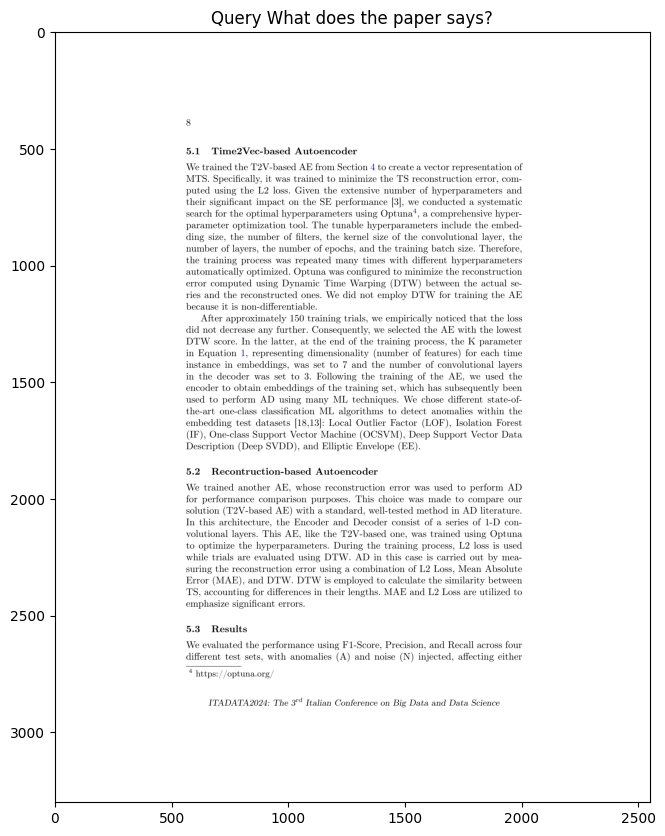

In [43]:
print_page(context_items[0]['page_number'])